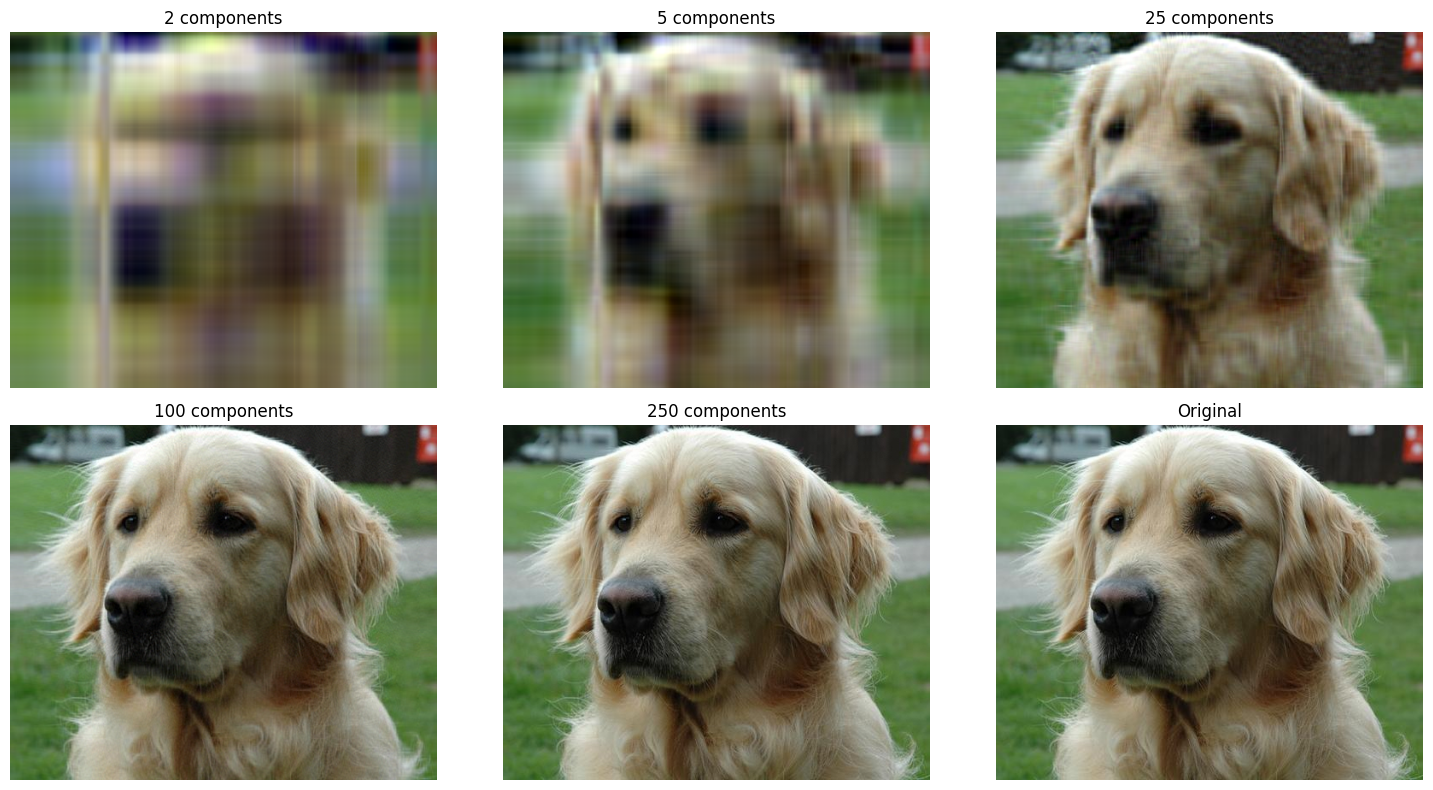

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def apply_pca_to_channel(channel, n_components):
    h, w = channel.shape
    channel_flattened = channel.reshape(h, -1)  # flatten
    pca = PCA(n_components=n_components)
    compressed = pca.fit_transform(channel_flattened)  # compression
    reconstructed = pca.inverse_transform(compressed)  # reconstruction
    return np.clip(reconstructed, 0, 255).astype(np.uint8)  

image_path = 'n02099601_146.jpg'  
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

R, G, B = cv2.split(image_rgb)

components_list = [2, 5, 25, 100, 250]

plt.figure(figsize=(15, 8))

for i, n_components in enumerate(components_list):
    
    R_pca = apply_pca_to_channel(R, n_components)
    G_pca = apply_pca_to_channel(G, n_components)
    B_pca = apply_pca_to_channel(B, n_components)

    image_pca = cv2.merge((R_pca, G_pca, B_pca)).astype(np.uint8) # merge reconstructed channels

    plt.subplot(2, 3, i+1)
    plt.title(f"{n_components} components")
    plt.imshow(image_pca)
    plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Original")
plt.imshow(image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

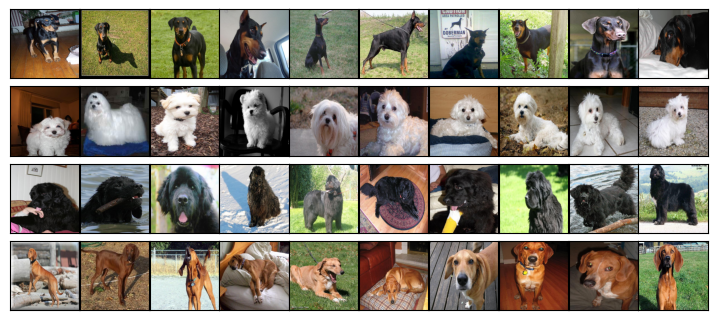

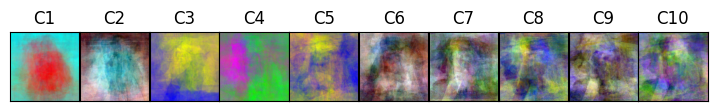

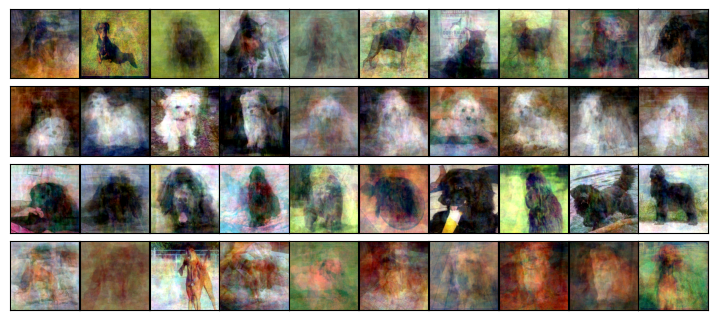

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from glob import iglob
import os

base_folder = 'reduced_dataset'
folders = ['doberman', 'maltese', 'newfoundland', 'redbone']

target_size = (224, 224)

dogs_list_r = []
dogs_list_g = []
dogs_list_b = []

for folder in folders:
    folder_path = os.path.join(base_folder, folder)
    for path in iglob(os.path.join(folder_path, '*.jpg')):
        img = cv2.imread(path)

        img_resized = cv2.resize(img, target_size)
        
        img_r, img_g, img_b = cv2.split(img_resized)
        
        dogs_list_r.append(pd.Series(img_r.flatten(), name=path))
        dogs_list_g.append(pd.Series(img_g.flatten(), name=path))
        dogs_list_b.append(pd.Series(img_b.flatten(), name=path))

dogs_r = pd.concat(dogs_list_r, axis=1).T
dogs_g = pd.concat(dogs_list_g, axis=1).T
dogs_b = pd.concat(dogs_list_b, axis=1).T

origs = []
for i in range(len(dogs_r)):
    orig = cv2.merge((dogs_r.iloc[i].values.reshape(target_size), 
                             dogs_g.iloc[i].values.reshape(target_size), 
                             dogs_b.iloc[i].values.reshape(target_size)))
    origs.append(orig)

fig, axes = plt.subplots(4, 10, figsize=(9, 4), subplot_kw={'xticks': [], 'yticks': []}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    orig_uint8 = np.clip(origs[i], 0, 255).astype(np.uint8)
    orig_image = cv2.cvtColor(orig_uint8, cv2.COLOR_BGR2RGB)
    ax.imshow(orig_image)

# perform PCA 80% variance
dogs_pca_r = PCA(n_components=0.8)
dogs_pca_r.fit(dogs_r)
dogs_pca_g = PCA(n_components=0.8)
dogs_pca_g.fit(dogs_g)
dogs_pca_b = PCA(n_components=0.8)
dogs_pca_b.fit(dogs_b)

num_components = min(10, dogs_pca_r.components_.shape[0]) 
fig, axes = plt.subplots(1, num_components, figsize=(9, 3), subplot_kw={'xticks': [], 'yticks': []}, gridspec_kw=dict(hspace=0.01, wspace=0.01))

for i, ax in enumerate(axes.flat):
    component_r = dogs_pca_r.components_[i].reshape(target_size)  
    component_g = dogs_pca_g.components_[i].reshape(target_size)  
    component_b = dogs_pca_b.components_[i].reshape(target_size)

    component_r = (component_r - np.min(component_r)) / (np.max(component_r) - np.min(component_r))
    component_g = (component_g - np.min(component_g)) / (np.max(component_g) - np.min(component_g))
    component_b = (component_b - np.min(component_b)) / (np.max(component_b) - np.min(component_b))

    component_r = (component_r * 255).astype(np.uint8)
    component_g = (component_g * 255).astype(np.uint8)
    component_b = (component_b * 255).astype(np.uint8)

    rgb_component = np.stack([component_r, component_g, component_b], axis=-1)
    ax.imshow(rgb_component[..., ::-1])
    ax.set_title(f'C{i+1}')

# trasnform color channels
components_r = dogs_pca_r.transform(dogs_r)
projected_r = dogs_pca_r.inverse_transform(components_r)
components_g = dogs_pca_g.transform(dogs_g)
projected_g = dogs_pca_g.inverse_transform(components_g)
components_b = dogs_pca_b.transform(dogs_b)
projected_b = dogs_pca_b.inverse_transform(components_b)


projected_r_reshaped = projected_r.reshape(dogs_r.shape[0], target_size[0], target_size[1])
projected_g_reshaped = projected_g.reshape(dogs_g.shape[0], target_size[0], target_size[1])
projected_b_reshaped = projected_b.reshape(dogs_b.shape[0], target_size[0], target_size[1])

projected_r_reshaped = np.clip(projected_r_reshaped, 0, 255)
projected_g_reshaped = np.clip(projected_g_reshaped, 0, 255)
projected_b_reshaped = np.clip(projected_b_reshaped, 0, 255)


reconstructed_images = []
for i in range(len(projected_r_reshaped)):
    merged_image = cv2.merge((projected_r_reshaped[i], projected_g_reshaped[i], projected_b_reshaped[i]))
    reconstructed_images.append(merged_image)

fig, axes = plt.subplots(4, 10, figsize=(9, 4), subplot_kw={'xticks': [], 'yticks': []}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    image_uint8 = np.clip(reconstructed_images[i], 0, 255).astype(np.uint8)
    rgb_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB)
    ax.imshow(rgb_image)